# Evasion Attacks (Defenses)

In this tutorial you will work with the same evasion attacks from last tutorial: FGSM and PGD. This time you will train a neural network on the MNIST dataset using both attacks to make the network more robust against evasion attacks. You will then attack the network and compare results. Next, you will also apply pruning to remove redundant parameters from a network to increase its efficiency while maintaining accuracy. Finally, we will have a look at one specific input transformation as defense at test time.

## Imports

Lets first import important packages. This includes the package [torchattacks](https://adversarial-attacks-pytorch.readthedocs.io/en/latest/attacks.html), a PyTorch library that provides adversarial attacks. 

In [1]:
# For plotting and computing
import copy
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import random

# PyTorch packages
import torch
from torch import optim
import torch.nn as nn
from torch.nn import Module
import torch.nn.functional as F
from torch.nn.functional import cross_entropy, softmax
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# This will install torchattacks if not yet present
#!pip install torchattacks
import torchattacks
import torchvision
import torchvision.transforms as transforms

# For Load Bar
from tqdm import tqdm

## Device

We also set the device variable so that we can easily switch from using cpu to gpu (if available).

In [2]:
# Define what device we are using
use_cuda=True
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA Available:  True


## Random Seed

Execute the code snippet below to set the random seed. This will ensure that you can reproduce results over multiple tries. So anyone who re-runs your code will get the exact same outputs.

For example: we will set shuffle to True and so the training loader will randomly shuffle the data over multiple runs. If you make changes to your code because training is not going well, then setting the random seed ensures that you can perform the training with the same samples as in previous tries. 

In [4]:
# Use this method to be able to reproduce results over multiple tries
def setup_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    # GPU operations have a separate seed we also want to set
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # Additionally, some operations on a GPU are implemented stochastic for efficiency
        # We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        
setup_seed(3131)

## Data

We already introduced the MNIST dataset in a previous tutorial where we trained and tested a MLP and CNN on it. It is an illustrative dataset that is also not to big and so training a new model does not take too much time. We make use of PyTorch's `DataLoader` class to create objects that we can use to sample training and test data using batches of size 100.

In [5]:
n_classes   = 10
img_size    = 28
channel     = 1
num_workers = 0
batch_size  = 100

def _init_fn(worker_id):
    np.random.seed(int(seed))

train_set = torchvision.datasets.MNIST(root='d:\Datasets', transform=transforms.ToTensor(), download=True, train=True)
train_loader = torch.utils.data.DataLoader(train_set,  batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True, worker_init_fn=_init_fn)

test_set = torchvision.datasets.MNIST(root='d:\Datasets', transform=transforms.ToTensor(), download=True, train=False)
test_loader = torch.utils.data.DataLoader(test_set,  batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True, worker_init_fn=_init_fn)

## Testing

The two methods below can be used to test a model and compute the performance (accuracy). Use the `test` method to compute the accuracy without adversarial attack and use the `adv_test` method, by providing a specific attack, to test the network using adversarial images. 

In [6]:
def test(model):
    print('\n\n[Plain/Test] Under Testing ... Please Wait')
    correct = 0
    total = 0
    
    with torch.no_grad():
        model.eval()
        for batch_idx, (inputs, targets) in enumerate(tqdm(test_loader)):
            inputs, targets = inputs.to(device), targets.to(device)
            # Evaluation
            outputs = model(inputs).detach()

            # Test
            _, predicted = torch.max(outputs, dim=1)
            total += targets.numel()
            correct += (predicted == targets).sum().item() 


        print('[Plain/Test] Acc: {:.3f}'.format(100.*correct / total))
    return 100.*correct / total


def adv_test(attack,model):
    correct = 0
    total = 0

    model.eval()
    print('\n\n[Adv/Test] Under Testing ... Please Wait')
    for batch_idx, (inputs, targets) in enumerate(tqdm(test_loader)):
        inputs, targets = inputs.to(device), targets.to(device)
        adv_inputs = attack(inputs, targets)

        # Evaluation
        outputs = model(adv_inputs).detach()

        # Test
        _, predicted = torch.max(outputs, dim=1)
        total += targets.numel()
        correct += (predicted == targets).sum().item() 

        
    print('[Adv/Test] Acc: {:.3f}'.format(100.*correct / total))
    return 100.*correct / total

## Neural Network

Here we provide a basic CNN network that we will train on the MNIST dataset and then use throughout the notebook. There are some new important parts added to this network, namely `self.record` and `self.mask`. We will use `self.record` to specify if we want the output of the second convolutional layer to be returned when `forward` is executed. This output we will need to perform pruning. Also used for pruning is `self.mask`. This is a special layer containing all ones and thus will simply output the input it gets. However, we can use this mask to specify which feature channel we want to prune by setting it to zero. More information on pruning at the end of this notebook. We will start with adversarial training.

In [7]:
class Model(nn.Module):          
    def __init__(self, **kwargs): 
        
        super(Model, self).__init__()
        
        self.record=False

        self.record_layer = {'conv1': True, 'conv2': True, 'fc1': True, 'fc2': True}

        self.prune_layer = {'conv1': False, 'conv2': True}

        # Convolutional layers
        self.conv1 = torch.nn.Conv2d(1, 16, 5, 1, 2) # in_channels, out_channels, kernel, stride, padding
        self.conv2 = torch.nn.Conv2d(16, 32, 5, 1, 2)
        
        self.mask = {'conv1': torch.ones(batch_size,16,28,28).to(device), 'conv2': torch.ones(batch_size,32,14,14).to(device)}
        
        # Fully connected layers
        self.fc1 = torch.nn.Linear(1568, 1024) 
        self.fc2 = torch.nn.Linear(1024, 10)

    def set_record(self,record):
        self.record=record

    def get_record(self):
        return self.record

    def set_mask(self,layer,mask):
        self.mask[layer] = mask

    def get_mask(self,layer):
        return self.mask[layer]

    def record_layer(self,layer: str,record: bool):
        self.record_layer[layer] = record

    def prune_layer(self,layer: str,prune: bool):
        self.prune_layer[layer] = prune
        
    def forward(self, x):
        output_dict = {}

        # convolutional layer 1
        x = self.conv1(x)
        # relu activation
        x = F.relu(x)
        # prune convolutional layer 1
        if self.prune_layer['conv1']:
            x = x * self.mask['conv1']
        # record convolutional layer 1
        if self.record_layer['conv1']:
            output_dict['conv1'] = x
        # max pooling 
        x = F.max_pool2d(x, 2, 2)

        # convolutional layer 2
        x = self.conv2(x)
        # relu activation
        x = F.relu(x)
        # prune convolutional layer 2
        if self.prune_layer['conv2']:
            x = x * self.mask['conv2']
        # record convolutional layer 2
        if self.record_layer['conv2']:
            output_dict['conv2'] =  x
        # max pooling
        x = F.max_pool2d(x, 2, 2)
        
        x = x.view(-1, np.prod(x.size()[1:]))

        # fully connected layer 1
        x = self.fc1(x)
        # relu activation
        x = F.relu(x)
        # record fully connected layer 1
        if self.record_layer['fc1']:
            output_dict['fc1'] = x

        # fully connected layer 2
        x = self.fc2(x)
        # softmax layer
        x = F.log_softmax(x, dim=1)
        # record fully connected layer 2
        if self.record_layer['fc2']:
            output_dict['fc2'] = x
        
        if self.record:
            self.record = False
            return x, output_dict
        else:
            return x

# Adversarial Training

With adversarial training you will use an evasion attack to create adversarial images and train your model using these images but then with the correct label. This way you can make a model robust against similar evasion attacks. Below you will find an adversarial training method that you can use to perform adversarial training. Examine the code to understand what is happening.

## Training

You can use the `adv_train` method below to perform adversarial training of a provided model. You will need to provide:
- neural network
- loss function
- optimization function
- attack
- number of epochs

We also added a normal `train` method for you to compare each type of training. As you can see only a few steps differ.

In [8]:
def adv_train(model,criterion,optimizer,attack=None,epochs=5):
    for epoch in range(epochs):
        print('\n\n[Adv/Epoch] : {}'.format(epoch+1))
        model.train()
        
        running_loss = 0
        correct = 0
        total = 0
        
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            # Prepare adversarial examples            
            adv_inputs = attack(inputs,targets)
            
            # Learning network parameters
            optimizer.zero_grad()
            
            # Using adversarial example to train
            outputs = model(adv_inputs.type(torch.FloatTensor).to(device))
            
            targets = targets.to(device)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            # Validation
            pred = torch.max(model(adv_inputs.type(torch.FloatTensor).to(device)).detach(), dim=1)[1]
            correct += torch.sum(pred.eq(targets)).item()
            total += targets.numel()

            running_loss += loss.item()

            if batch_idx % 50 == 0 and batch_idx != 0:
                print('[Adv/Train] Iter: {}, Acc: {:.3f}, Loss: {:.3f}'.format(
                    batch_idx, # Iter
                    100.*correct / total, # Acc
                    running_loss / (batch_idx+1) # CrossEntropy
                    )
                )
        
        # Test
        test(model)
        adv_test(attack,model)

In [9]:
def train(model,criterion,optimizer,scheduler=None,epochs=5):
    for epoch in range(epochs):
        print('\n\n[Plain/Epoch] : {}'.format(epoch+1))
        model.train()
        
        running_loss = 0
        correct = 0
        total = 0

        for batch_idx, (inputs, targets) in enumerate(train_loader):
            # No adversarial examples prepared

            # Learning network parameters
            optimizer.zero_grad()
            
            # Using normal input images for training
            outputs = model(inputs.type(torch.FloatTensor).to(device))
            
            targets = targets.to(device)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            # Validation
            pred = torch.max(model(inputs.type(torch.FloatTensor).to(device)).detach(), dim=1)[1]
            correct += torch.sum(pred.eq(targets)).item()
            total += targets.numel()

            running_loss += loss.item()

            if batch_idx % 50 == 0 and batch_idx != 0:
                print('[Plain/Train] Iter: {}, Acc: {:.3f}, Loss: {:.3f}'.format(
                    batch_idx, # Iter
                    100.*correct / total, # Acc
                    running_loss / (batch_idx+1) # CrossEntropy
                    )
                )

        # Test
        test(model)

Using the `adv_train()` method you will train two robust models. One using FGSM and one using PGD. Then you will test your model using clean images, FGSM adversarial images and PGD adversarial images. In the end you will compare the accuracy in all cases.

## FGSM Adversarial Training

First we define some hyperparameters and a optimization and loss function. We also use the `torchattacks` library to define a FGSM and PGD attack.

In [10]:
eps=0.3
alpha=0.01
lr=0.1

fgsm_net = Model().to(device)

optimizer = torch.optim.SGD(fgsm_net.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()

# Create attacks for FGSM network
attack_fgsm = torchattacks.FGSM(model=fgsm_net, eps=eps)
attack_pgd = torchattacks.PGD(model=fgsm_net,eps=eps,alpha=alpha,steps=10,random_start=True)

We start adversarial training using FGSM. Execute the following code block to perform adversarial training. See the `adv_train` code block above for details to check how the attack is used to train the model.

In [11]:
adv_train(fgsm_net,criterion,optimizer,attack=attack_fgsm)



[Adv/Epoch] : 1
[Adv/Train] Iter: 50, Acc: 10.961, Loss: 2.306
[Adv/Train] Iter: 100, Acc: 18.257, Loss: 2.287
[Adv/Train] Iter: 150, Acc: 21.212, Loss: 2.258
[Adv/Train] Iter: 200, Acc: 24.090, Loss: 2.216
[Adv/Train] Iter: 250, Acc: 27.135, Loss: 2.164
[Adv/Train] Iter: 300, Acc: 30.272, Loss: 2.102
[Adv/Train] Iter: 350, Acc: 33.630, Loss: 2.032
[Adv/Train] Iter: 400, Acc: 36.933, Loss: 1.957
[Adv/Train] Iter: 450, Acc: 40.098, Loss: 1.879
[Adv/Train] Iter: 500, Acc: 43.391, Loss: 1.798
[Adv/Train] Iter: 550, Acc: 45.953, Loss: 1.736


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 100/100 [00:01<00:00, 56.02it/s]


[Plain/Test] Acc: 95.050


[Adv/Test] Under Testing ... Please Wait


100%|██████████| 100/100 [00:02<00:00, 41.56it/s]


[Adv/Test] Acc: 66.440


[Adv/Epoch] : 2
[Adv/Train] Iter: 50, Acc: 73.078, Loss: 1.033
[Adv/Train] Iter: 100, Acc: 72.950, Loss: 1.026
[Adv/Train] Iter: 150, Acc: 73.954, Loss: 0.989
[Adv/Train] Iter: 200, Acc: 75.368, Loss: 0.941
[Adv/Train] Iter: 250, Acc: 75.964, Loss: 0.922
[Adv/Train] Iter: 300, Acc: 77.070, Loss: 0.886
[Adv/Train] Iter: 350, Acc: 78.105, Loss: 0.854
[Adv/Train] Iter: 400, Acc: 79.252, Loss: 0.820
[Adv/Train] Iter: 450, Acc: 79.758, Loss: 0.808
[Adv/Train] Iter: 500, Acc: 80.389, Loss: 0.787
[Adv/Train] Iter: 550, Acc: 81.009, Loss: 0.767


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 100/100 [00:01<00:00, 55.37it/s]


[Plain/Test] Acc: 96.370


[Adv/Test] Under Testing ... Please Wait


100%|██████████| 100/100 [00:02<00:00, 39.48it/s]


[Adv/Test] Acc: 80.260


[Adv/Epoch] : 3
[Adv/Train] Iter: 50, Acc: 87.765, Loss: 0.540
[Adv/Train] Iter: 100, Acc: 87.921, Loss: 0.540
[Adv/Train] Iter: 150, Acc: 87.881, Loss: 0.543
[Adv/Train] Iter: 200, Acc: 88.552, Loss: 0.520
[Adv/Train] Iter: 250, Acc: 88.542, Loss: 0.526
[Adv/Train] Iter: 300, Acc: 88.050, Loss: 0.547
[Adv/Train] Iter: 350, Acc: 88.199, Loss: 0.543
[Adv/Train] Iter: 400, Acc: 88.100, Loss: 0.547
[Adv/Train] Iter: 450, Acc: 87.763, Loss: 0.559
[Adv/Train] Iter: 500, Acc: 87.699, Loss: 0.561
[Adv/Train] Iter: 550, Acc: 87.848, Loss: 0.554


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 100/100 [00:01<00:00, 56.63it/s]


[Plain/Test] Acc: 96.600


[Adv/Test] Under Testing ... Please Wait


100%|██████████| 100/100 [00:02<00:00, 42.00it/s]


[Adv/Test] Acc: 86.760


[Adv/Epoch] : 4
[Adv/Train] Iter: 50, Acc: 91.765, Loss: 0.432
[Adv/Train] Iter: 100, Acc: 87.317, Loss: 0.589
[Adv/Train] Iter: 150, Acc: 87.669, Loss: 0.574
[Adv/Train] Iter: 200, Acc: 89.468, Loss: 0.508
[Adv/Train] Iter: 250, Acc: 89.729, Loss: 0.500
[Adv/Train] Iter: 300, Acc: 90.292, Loss: 0.481
[Adv/Train] Iter: 350, Acc: 91.174, Loss: 0.447
[Adv/Train] Iter: 400, Acc: 92.047, Loss: 0.412
[Adv/Train] Iter: 450, Acc: 92.712, Loss: 0.382
[Adv/Train] Iter: 500, Acc: 92.525, Loss: 0.395
[Adv/Train] Iter: 550, Acc: 92.608, Loss: 0.391


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 100/100 [00:02<00:00, 43.96it/s]


[Plain/Test] Acc: 89.150


[Adv/Test] Under Testing ... Please Wait


100%|██████████| 100/100 [00:03<00:00, 32.00it/s]


[Adv/Test] Acc: 88.920


[Adv/Epoch] : 5
[Adv/Train] Iter: 50, Acc: 97.196, Loss: 0.210
[Adv/Train] Iter: 100, Acc: 96.931, Loss: 0.215
[Adv/Train] Iter: 150, Acc: 96.887, Loss: 0.213
[Adv/Train] Iter: 200, Acc: 97.070, Loss: 0.206
[Adv/Train] Iter: 250, Acc: 97.227, Loss: 0.198
[Adv/Train] Iter: 300, Acc: 97.369, Loss: 0.192
[Adv/Train] Iter: 350, Acc: 97.519, Loss: 0.184
[Adv/Train] Iter: 400, Acc: 97.731, Loss: 0.174
[Adv/Train] Iter: 450, Acc: 97.920, Loss: 0.165
[Adv/Train] Iter: 500, Acc: 98.078, Loss: 0.156
[Adv/Train] Iter: 550, Acc: 98.205, Loss: 0.149


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 100/100 [00:02<00:00, 43.25it/s]


[Plain/Test] Acc: 84.020


[Adv/Test] Under Testing ... Please Wait


100%|██████████| 100/100 [00:03<00:00, 32.09it/s]

[Adv/Test] Acc: 97.880


Now we want to check the performance of the FGSM trained model. First we will test the model using clean input. Then we will use FGSM to test the model using adversarial images and finally we will do the same using PGD. Attacking the model using PGD should result in a very low performance as FGSM does not make the model robust against it. 

In [12]:
fgsm_net_scores = []

In [13]:
fgsm_net_scores.append(test(fgsm_net))



[Plain/Test] Under Testing ... Please Wait


100%|██████████| 100/100 [00:02<00:00, 42.28it/s]

[Plain/Test] Acc: 84.020


In [14]:
fgsm_net_scores.append(adv_test(attack_fgsm,fgsm_net))



[Adv/Test] Under Testing ... Please Wait


100%|██████████| 100/100 [00:02<00:00, 33.73it/s]

[Adv/Test] Acc: 97.880


In [15]:
fgsm_net_scores.append(adv_test(attack_pgd,fgsm_net))



[Adv/Test] Under Testing ... Please Wait


100%|██████████| 100/100 [00:08<00:00, 11.42it/s]

[Adv/Test] Acc: 1.540


## PGD Adversarial Training

Now lets train the model using PGD.

In [16]:
eps=0.3
alpha=0.01
lr=0.1

pgd_net = Model().to(device)

optimizer = torch.optim.SGD(pgd_net.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()

# Create attacks for PGD network
attack_pgd = torchattacks.PGD(model=pgd_net,eps=eps,alpha=alpha,steps=10,random_start=True)
attack_fgsm = torchattacks.FGSM(model=pgd_net, eps=eps)

In [17]:
adv_train(pgd_net,criterion,optimizer,attack=attack_pgd)



[Adv/Epoch] : 1
[Adv/Train] Iter: 50, Acc: 18.157, Loss: 2.281
[Adv/Train] Iter: 100, Acc: 35.762, Loss: 1.993
[Adv/Train] Iter: 150, Acc: 47.808, Loss: 1.691
[Adv/Train] Iter: 200, Acc: 55.831, Loss: 1.473
[Adv/Train] Iter: 250, Acc: 61.637, Loss: 1.301
[Adv/Train] Iter: 300, Acc: 65.983, Loss: 1.174
[Adv/Train] Iter: 350, Acc: 69.422, Loss: 1.073
[Adv/Train] Iter: 400, Acc: 72.077, Loss: 0.995
[Adv/Train] Iter: 450, Acc: 74.313, Loss: 0.926
[Adv/Train] Iter: 500, Acc: 76.168, Loss: 0.870
[Adv/Train] Iter: 550, Acc: 77.717, Loss: 0.821


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 100/100 [00:02<00:00, 40.67it/s]


[Plain/Test] Acc: 97.560


[Adv/Test] Under Testing ... Please Wait


100%|██████████| 100/100 [00:08<00:00, 11.54it/s]


[Adv/Test] Acc: 90.350


[Adv/Epoch] : 2
[Adv/Train] Iter: 50, Acc: 94.431, Loss: 0.306
[Adv/Train] Iter: 100, Acc: 94.416, Loss: 0.300
[Adv/Train] Iter: 150, Acc: 94.775, Loss: 0.286
[Adv/Train] Iter: 200, Acc: 94.677, Loss: 0.286
[Adv/Train] Iter: 250, Acc: 94.809, Loss: 0.282
[Adv/Train] Iter: 300, Acc: 95.033, Loss: 0.276
[Adv/Train] Iter: 350, Acc: 95.151, Loss: 0.271
[Adv/Train] Iter: 400, Acc: 95.367, Loss: 0.265
[Adv/Train] Iter: 450, Acc: 95.501, Loss: 0.261
[Adv/Train] Iter: 500, Acc: 95.583, Loss: 0.259
[Adv/Train] Iter: 550, Acc: 95.635, Loss: 0.257


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 100/100 [00:02<00:00, 42.87it/s]


[Plain/Test] Acc: 98.500


[Adv/Test] Under Testing ... Please Wait


100%|██████████| 100/100 [00:08<00:00, 11.54it/s]


[Adv/Test] Acc: 93.160


[Adv/Epoch] : 3
[Adv/Train] Iter: 50, Acc: 97.235, Loss: 0.210
[Adv/Train] Iter: 100, Acc: 97.406, Loss: 0.201
[Adv/Train] Iter: 150, Acc: 97.245, Loss: 0.204
[Adv/Train] Iter: 200, Acc: 97.104, Loss: 0.208
[Adv/Train] Iter: 250, Acc: 97.195, Loss: 0.205
[Adv/Train] Iter: 300, Acc: 97.249, Loss: 0.204
[Adv/Train] Iter: 350, Acc: 97.225, Loss: 0.204
[Adv/Train] Iter: 400, Acc: 97.244, Loss: 0.202
[Adv/Train] Iter: 450, Acc: 97.259, Loss: 0.201
[Adv/Train] Iter: 500, Acc: 97.251, Loss: 0.201
[Adv/Train] Iter: 550, Acc: 97.305, Loss: 0.198


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 100/100 [00:02<00:00, 41.07it/s]


[Plain/Test] Acc: 98.640


[Adv/Test] Under Testing ... Please Wait


100%|██████████| 100/100 [00:09<00:00, 10.82it/s]


[Adv/Test] Acc: 93.550


[Adv/Epoch] : 4
[Adv/Train] Iter: 50, Acc: 98.157, Loss: 0.158
[Adv/Train] Iter: 100, Acc: 98.307, Loss: 0.158
[Adv/Train] Iter: 150, Acc: 98.225, Loss: 0.161
[Adv/Train] Iter: 200, Acc: 98.179, Loss: 0.162
[Adv/Train] Iter: 250, Acc: 98.147, Loss: 0.164
[Adv/Train] Iter: 300, Acc: 98.143, Loss: 0.164
[Adv/Train] Iter: 350, Acc: 98.105, Loss: 0.165
[Adv/Train] Iter: 400, Acc: 98.075, Loss: 0.164
[Adv/Train] Iter: 450, Acc: 98.078, Loss: 0.164
[Adv/Train] Iter: 500, Acc: 98.092, Loss: 0.164
[Adv/Train] Iter: 550, Acc: 98.111, Loss: 0.163


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 100/100 [00:02<00:00, 43.12it/s]


[Plain/Test] Acc: 98.870


[Adv/Test] Under Testing ... Please Wait


100%|██████████| 100/100 [00:08<00:00, 11.49it/s]


[Adv/Test] Acc: 94.380


[Adv/Epoch] : 5
[Adv/Train] Iter: 50, Acc: 98.451, Loss: 0.139
[Adv/Train] Iter: 100, Acc: 98.426, Loss: 0.146
[Adv/Train] Iter: 150, Acc: 98.384, Loss: 0.144
[Adv/Train] Iter: 200, Acc: 98.453, Loss: 0.142
[Adv/Train] Iter: 250, Acc: 98.486, Loss: 0.140
[Adv/Train] Iter: 300, Acc: 98.498, Loss: 0.141
[Adv/Train] Iter: 350, Acc: 98.527, Loss: 0.140
[Adv/Train] Iter: 400, Acc: 98.554, Loss: 0.139
[Adv/Train] Iter: 450, Acc: 98.539, Loss: 0.139
[Adv/Train] Iter: 500, Acc: 98.521, Loss: 0.141
[Adv/Train] Iter: 550, Acc: 98.523, Loss: 0.141


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 100/100 [00:02<00:00, 42.44it/s]


[Plain/Test] Acc: 98.900


[Adv/Test] Under Testing ... Please Wait


100%|██████████| 100/100 [00:09<00:00, 10.97it/s]

[Adv/Test] Acc: 95.030


After training the model with PGD compute the different performance scores below. This time attacking the model using PGD should not result in a bad performance. Also attacking with FGSM should result in a lower performance but still not too bad. What is interesting to see is that the performance using clean images is high, which was not the case when training with FGSM. This is due to with FGSM training we encounter the problem of label leaking. Label leaking makes the accuracy on adversarial examples higher than on clean images. The reason is explained in the paper [*Adversarial Machine Learning At Scale, by Kurakin, Goodfellow and Bengio*](https://arxiv.org/abs/1611.01236), which is that FGSM is actually just one step. This means that the adversarial examples found are not that diverse and we use the true label when training FGSM. So the network learns a special pattern related to the true label in the adversarial examples and does not learn enough information in clean examples.

In [18]:
pgd_net_scores = []

In [19]:
pgd_net_scores.append(test(pgd_net))



[Plain/Test] Under Testing ... Please Wait


100%|██████████| 100/100 [00:03<00:00, 30.83it/s]

[Plain/Test] Acc: 98.900


In [20]:
pgd_net_scores.append(adv_test(attack_fgsm,pgd_net))



[Adv/Test] Under Testing ... Please Wait


100%|██████████| 100/100 [00:03<00:00, 30.24it/s]

[Adv/Test] Acc: 69.970


In [21]:
pgd_net_scores.append(adv_test(attack_pgd,pgd_net))



[Adv/Test] Under Testing ... Please Wait


100%|██████████| 100/100 [00:09<00:00, 10.14it/s]

[Adv/Test] Acc: 95.150


Use the code below to plot all performance scores and compare the scores for normal training and adversarial training.

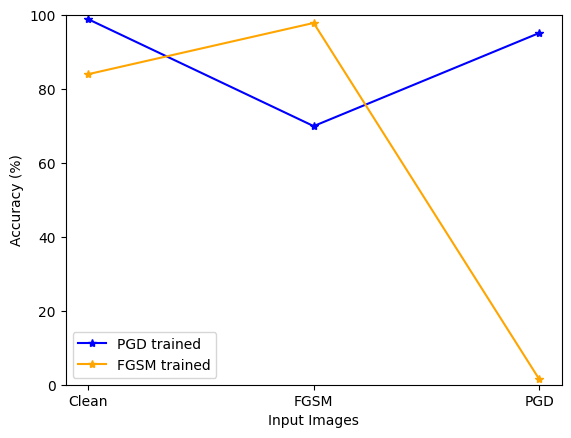

In [22]:
labels = ['Clean', 'FGSM', 'PGD']
plt.plot(labels,pgd_net_scores,'b*-',label="PGD trained")
plt.plot(labels,fgsm_net_scores,'*-',color='orange',label="FGSM trained")
plt.ylim(ymin=0,ymax=100)
plt.ylabel("Accuracy (%)")
plt.xlabel("Input Images")
plt.legend()
plt.show()

# Pruning as a defense

Next we will show you how to perform the very simple method of adversarial examples related pruning. The idea is to check the distance between outputs of hidden layers when you input clean data and adversarial data. The distance can be quantified by $L_2$ norm.


The parts with a large distance should be pruned. To make it simple, we can just set the elements in that part to 0. 
For example, we can use feature channels as unit for pruning. The second convolutional layer of our network (`Model()`) outputs a feature map which consists of a few 32 feature channels.
As the input is passed in `forward()` layer by layer, we can add a mask with the same shape for output of the second convolutional layer.
If want to remove a feature channels, we just need to set the corresponding part in the mask to 0.

First lets define new hyperparameters, a new model named `net` and the FGSM attack for this section of the notebook. After this train the new model.

In [23]:
eps = 0.2
alpha = 0.01
lr = 0.1

net = Model().to(device)

optimizer = torch.optim.SGD(net.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()

In [24]:
attack_fgsm = torchattacks.FGSM(model=net,eps=eps)

In [25]:
train(net,criterion,optimizer)



[Plain/Epoch] : 1
[Plain/Train] Iter: 50, Acc: 51.686, Loss: 1.711
[Plain/Train] Iter: 100, Acc: 69.079, Loss: 1.136
[Plain/Train] Iter: 150, Acc: 77.351, Loss: 0.853
[Plain/Train] Iter: 200, Acc: 81.980, Loss: 0.697
[Plain/Train] Iter: 250, Acc: 85.012, Loss: 0.593
[Plain/Train] Iter: 300, Acc: 87.096, Loss: 0.523
[Plain/Train] Iter: 350, Acc: 88.650, Loss: 0.469
[Plain/Train] Iter: 400, Acc: 89.878, Loss: 0.426
[Plain/Train] Iter: 450, Acc: 90.867, Loss: 0.392
[Plain/Train] Iter: 500, Acc: 91.661, Loss: 0.363
[Plain/Train] Iter: 550, Acc: 92.289, Loss: 0.340


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 100/100 [00:01<00:00, 55.28it/s]


[Plain/Test] Acc: 97.630


[Plain/Epoch] : 2
[Plain/Train] Iter: 50, Acc: 99.294, Loss: 0.079
[Plain/Train] Iter: 100, Acc: 99.347, Loss: 0.084
[Plain/Train] Iter: 150, Acc: 99.258, Loss: 0.086
[Plain/Train] Iter: 200, Acc: 99.284, Loss: 0.085
[Plain/Train] Iter: 250, Acc: 99.319, Loss: 0.083
[Plain/Train] Iter: 300, Acc: 99.359, Loss: 0.082
[Plain/Train] Iter: 350, Acc: 99.390, Loss: 0.079
[Plain/Train] Iter: 400, Acc: 99.426, Loss: 0.078
[Plain/Train] Iter: 450, Acc: 99.430, Loss: 0.078
[Plain/Train] Iter: 500, Acc: 99.455, Loss: 0.076
[Plain/Train] Iter: 550, Acc: 99.475, Loss: 0.075


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 100/100 [00:02<00:00, 49.26it/s]


[Plain/Test] Acc: 98.180


[Plain/Epoch] : 3
[Plain/Train] Iter: 50, Acc: 99.706, Loss: 0.057
[Plain/Train] Iter: 100, Acc: 99.604, Loss: 0.059
[Plain/Train] Iter: 150, Acc: 99.623, Loss: 0.058
[Plain/Train] Iter: 200, Acc: 99.662, Loss: 0.056
[Plain/Train] Iter: 250, Acc: 99.693, Loss: 0.053
[Plain/Train] Iter: 300, Acc: 99.698, Loss: 0.054
[Plain/Train] Iter: 350, Acc: 99.712, Loss: 0.053
[Plain/Train] Iter: 400, Acc: 99.716, Loss: 0.052
[Plain/Train] Iter: 450, Acc: 99.729, Loss: 0.052
[Plain/Train] Iter: 500, Acc: 99.735, Loss: 0.053
[Plain/Train] Iter: 550, Acc: 99.748, Loss: 0.052


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 100/100 [00:01<00:00, 55.71it/s]


[Plain/Test] Acc: 98.160


[Plain/Epoch] : 4
[Plain/Train] Iter: 50, Acc: 99.725, Loss: 0.044
[Plain/Train] Iter: 100, Acc: 99.802, Loss: 0.041
[Plain/Train] Iter: 150, Acc: 99.808, Loss: 0.040
[Plain/Train] Iter: 200, Acc: 99.841, Loss: 0.040
[Plain/Train] Iter: 250, Acc: 99.853, Loss: 0.039
[Plain/Train] Iter: 300, Acc: 99.844, Loss: 0.040
[Plain/Train] Iter: 350, Acc: 99.852, Loss: 0.040
[Plain/Train] Iter: 400, Acc: 99.848, Loss: 0.040
[Plain/Train] Iter: 450, Acc: 99.854, Loss: 0.039
[Plain/Train] Iter: 500, Acc: 99.848, Loss: 0.039
[Plain/Train] Iter: 550, Acc: 99.855, Loss: 0.039


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 100/100 [00:01<00:00, 56.12it/s]


[Plain/Test] Acc: 98.350


[Plain/Epoch] : 5
[Plain/Train] Iter: 50, Acc: 99.922, Loss: 0.032
[Plain/Train] Iter: 100, Acc: 99.891, Loss: 0.032
[Plain/Train] Iter: 150, Acc: 99.894, Loss: 0.032
[Plain/Train] Iter: 200, Acc: 99.910, Loss: 0.031
[Plain/Train] Iter: 250, Acc: 99.912, Loss: 0.032
[Plain/Train] Iter: 300, Acc: 99.914, Loss: 0.032
[Plain/Train] Iter: 350, Acc: 99.923, Loss: 0.031
[Plain/Train] Iter: 400, Acc: 99.925, Loss: 0.032
[Plain/Train] Iter: 450, Acc: 99.920, Loss: 0.031
[Plain/Train] Iter: 500, Acc: 99.924, Loss: 0.031
[Plain/Train] Iter: 550, Acc: 99.922, Loss: 0.032


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 100/100 [00:02<00:00, 42.83it/s]

[Plain/Test] Acc: 98.950


Lets see what the clean and FGSM attacked accuracies are:

In [26]:
test(net)
adv_test(attack_fgsm,net)



[Plain/Test] Under Testing ... Please Wait


100%|██████████| 100/100 [00:02<00:00, 42.53it/s]


[Plain/Test] Acc: 98.950


[Adv/Test] Under Testing ... Please Wait


100%|██████████| 100/100 [00:03<00:00, 28.35it/s]

[Adv/Test] Acc: 21.270


21.27

## Compute the distance between outputs of the second convolutional layer (net.conv2)

Here we use a simple way to get the output of a specific hidden layer.
In the `forward()` function, we keep some of the intermediate results in the list `output_list`.
The `output_list` is returned when `net.record` is `True`.

Then we search for the part most likely related to adversarial attacks.
If we prune (set it to 0) it, the model is supposed to be less sensitive to adversarial examples.


**How to evaluate the relevance of hidden layers and adversarial attack?**


We use feature channels as the unit to evaluate it. A convolutional layer will output multiple feature channels. Each channel represent a feature learned by the model. 

When we input clean data and adversarial examples, if a feature channel then changes a lot, it means the channel is sensitive to adversarial perturbation. The channel is very related to adversarial attack.

This difference of feature channels can be quantified by $L_2$ norm, Euclidean distance.

Now run the following code to compute the distance between the output of conv2 with clean and adversarial input.

In [27]:
def compute_distance_output_conv2(net,attack):
    distance_results = [0 for i in range(32)]
    topn = 1
    
    for batch_idx, (inputs, targets) in enumerate(tqdm(test_loader)):
        inputs, targets = inputs.to(device), targets.to(device)

        # Get the output of convoluational layer 2 (conv2) with clean inputs   
        net.set_record(True)
        clean_output, clean_features = net(inputs)

        adv_inputs = attack_fgsm(inputs, targets)

        # Get the output of convoluational layer 2 (conv2) with adversarial inputs   
        net.set_record(True)
        adv_output, adv_features = net(adv_inputs)

        # In order to facilitate the calculation of the distance, 
        # reshape the feature channels of conv2, from 14*14 to 196.
        clean_conv2_features = clean_features['conv2'].view(100, 32, -1) 
        adv_conv2_features = adv_features['conv2'].view(100, 32, -1)

        # 100 pieces of data at each iteration, 32 feature channels
        for data_id in range(100):
            distance_tensor = torch.Tensor(32)
            for feature_id in range(32):
                # Compute Euclidean distance
                distance = (clean_conv2_features[data_id][feature_id] - adv_conv2_features[data_id][feature_id]).pow(2).sum().sqrt()
                distance_tensor[feature_id] = distance


            # From every 32 channels, we record the furthest distance, top 1 (topn=1).
            # You could also decide to record the top 2 or top 3
            # Feel free to experiment with this number
            for feature_id in torch.topk(distance_tensor, topn)[1]:
                distance_results[feature_id] += 1
                
    return distance_results

In [28]:
dis_results = compute_distance_output_conv2(net,attack_fgsm)

100%|██████████| 100/100 [01:49<00:00,  1.10s/it]


In [29]:
def plot_distances(dis_results):
    data = []
    for i, count in enumerate(dis_results):
        for _ in range(count):
            data.append(i)
    bins=np.arange(33)-0.5
    plt.hist(data,bins=bins)
    plt.xticks(range(0,33,2))
    plt.xlim([-1,34])
    plt.show()

Using the `plot_distance()` method will help to visualize how many times each feature channel resulted in the greatest distance. We are interested in those channels that most times resulted in the greatest distance. We can then decide to prune the top one or multiple in order to see what has the greatest effect on robustness.

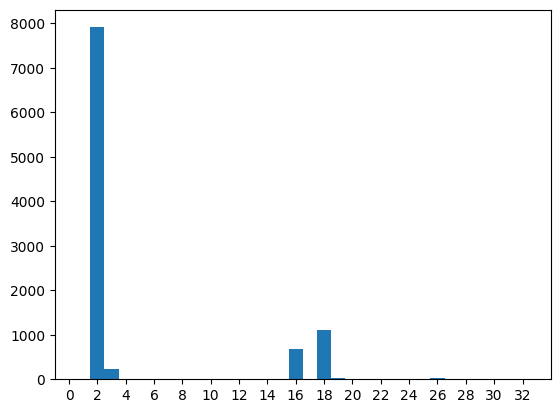

In [30]:
plot_distances(dis_results)

Note that, even when a channel is recorded many time in `dis_results`, pruning it will not always increase the robustness. It is possible for these channels to still contain useful information. We cannot completely separate information related to adversarial attacks from other information.
However, removing these recorded channels is more likely to improve robustness.

Below you can specify which channel you want to prune in our network and then test it to get a performance score. Try out different channels and see for yourself what effect pruning these channels has on the robustness of the network. 

In [32]:
# Reset network mask to contain all ones
net.set_mask('conv2',torch.ones(batch_size,32,14,14).to(device))

# Try out different channel ids for yourself
remove_ids = [2,]

# Prune specified channel ids
for i in remove_ids:
    mask = net.get_mask('conv2')
    mask[:,i,:,:] = mask[:,i,:,:] * 0
    net.set_mask('conv2',mask)
    
clean_acc_pruning = test(net)
adv_acc_pruning = adv_test(attack_fgsm,net)

# Reset network mask to contain all ones
net.set_mask('conv2',torch.ones(batch_size,32,14,14).to(device))

clean_acc = test(net)
adv_acc = adv_test(attack_fgsm,net)



[Plain/Test] Under Testing ... Please Wait


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:02<00:00, 42.57it/s]


[Plain/Test] Acc: 98.730


[Adv/Test] Under Testing ... Please Wait


100%|██████████| 100/100 [00:02<00:00, 35.17it/s]


[Adv/Test] Acc: 23.380


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 100/100 [00:01<00:00, 52.14it/s]


[Plain/Test] Acc: 98.950


[Adv/Test] Under Testing ... Please Wait


100%|██████████| 100/100 [00:02<00:00, 38.79it/s]

[Adv/Test] Acc: 21.270


Use the code below to plot the performance of the network using either clean or adversarial input and with or without pruning. Even when you tried many different channel ids or combination of channel ids to prune, it could be that the defense effect is only small. This is the case because pruning is a very naive defense. Like we mentioned before, some feature channels that seem might be an excellent candidate to prune could still hold useful information for the task at hand. As we cannot completely separate this information, pruning these channels can also harm the performance of the model. With this kind of defense, only a small improvement in accuracy is already very good.

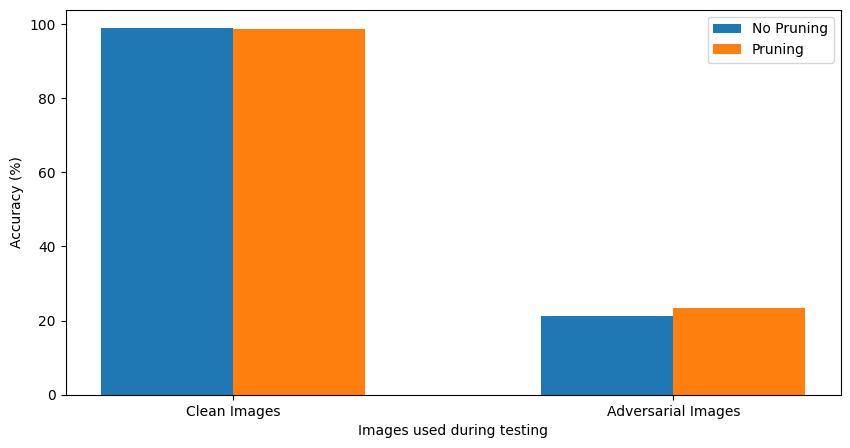

In [33]:
no_pruning = [clean_acc,adv_acc]
pruning = [clean_acc_pruning,adv_acc_pruning]

ind = np.arange(2)

plt.figure(figsize=(10,5))

width=0.3

plt.bar(ind,no_pruning, width, label='No Pruning')
plt.bar(ind+width,pruning,width,label="Pruning")

plt.xlabel('Images used during testing')
plt.ylabel('Accuracy (%)')

# xticks()
# First argument - A list of positions at which ticks should be placed
# Second argument -  A list of labels to place at the given locations
plt.xticks(ind + width / 2, ('Clean Images', 'Adversarial Images'))

# Finding the best position for legends and putting it
plt.legend(loc='best')
plt.show()

The previous two defenses are defenses applied during training (pruning after a first iteration of training but at certainly before deployment). Next we will show you a defense you can apply after training. It is very easy and also not the best defense, but still it can be effective.

# Input Transformation as Defense

In this section we will show you how you can implement one kind of input transformation as defense. This defense is applied at inference time, so after training. In this tutorial we will apply JPEG compression as input transformation defense. This means that after training the model and deploying it we will apply JPEG compression to any input to the model. This is as simple as saving the images in JPEG format and then loading them again just before we feed them to the model. By compressing the images to JPEG, you are lowering the quality of the input images. The idea is that the effect of the adversarial perturbation on the input image will be removed by compressing the image to a lower quality. In this section, you will apply this defense and see its effect on the accuracy of your CNN model.

First we train a model, lets call it `cnn_model` as it is a CNN, on the clean training data of MNIST. You can run the code snippet below to start training. 

In [34]:
# Train model
eps = 0.2
alpha = 0.01
lr = 0.1

cnn_model = Model().to(device)

optimizer = torch.optim.SGD(cnn_model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()

train(cnn_model,criterion,optimizer,scheduler=None,epochs=5)



[Plain/Epoch] : 1
[Plain/Train] Iter: 50, Acc: 49.824, Loss: 1.847
[Plain/Train] Iter: 100, Acc: 68.465, Loss: 1.202
[Plain/Train] Iter: 150, Acc: 76.921, Loss: 0.901
[Plain/Train] Iter: 200, Acc: 81.861, Loss: 0.727
[Plain/Train] Iter: 250, Acc: 84.952, Loss: 0.616
[Plain/Train] Iter: 300, Acc: 87.163, Loss: 0.537
[Plain/Train] Iter: 350, Acc: 88.752, Loss: 0.480
[Plain/Train] Iter: 400, Acc: 89.968, Loss: 0.436
[Plain/Train] Iter: 450, Acc: 90.931, Loss: 0.400
[Plain/Train] Iter: 500, Acc: 91.731, Loss: 0.370
[Plain/Train] Iter: 550, Acc: 92.407, Loss: 0.346


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 100/100 [00:02<00:00, 48.59it/s]


[Plain/Test] Acc: 97.580


[Plain/Epoch] : 2
[Plain/Train] Iter: 50, Acc: 99.333, Loss: 0.082
[Plain/Train] Iter: 100, Acc: 99.228, Loss: 0.083
[Plain/Train] Iter: 150, Acc: 99.238, Loss: 0.083
[Plain/Train] Iter: 200, Acc: 99.294, Loss: 0.082
[Plain/Train] Iter: 250, Acc: 99.315, Loss: 0.082
[Plain/Train] Iter: 300, Acc: 99.362, Loss: 0.078
[Plain/Train] Iter: 350, Acc: 99.379, Loss: 0.077
[Plain/Train] Iter: 400, Acc: 99.397, Loss: 0.076
[Plain/Train] Iter: 450, Acc: 99.421, Loss: 0.074
[Plain/Train] Iter: 500, Acc: 99.433, Loss: 0.072
[Plain/Train] Iter: 550, Acc: 99.461, Loss: 0.071


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 100/100 [00:01<00:00, 50.35it/s]


[Plain/Test] Acc: 98.420


[Plain/Epoch] : 3
[Plain/Train] Iter: 50, Acc: 99.706, Loss: 0.059
[Plain/Train] Iter: 100, Acc: 99.713, Loss: 0.053
[Plain/Train] Iter: 150, Acc: 99.755, Loss: 0.051
[Plain/Train] Iter: 200, Acc: 99.731, Loss: 0.053
[Plain/Train] Iter: 250, Acc: 99.761, Loss: 0.052
[Plain/Train] Iter: 300, Acc: 99.754, Loss: 0.052
[Plain/Train] Iter: 350, Acc: 99.758, Loss: 0.052
[Plain/Train] Iter: 400, Acc: 99.773, Loss: 0.050
[Plain/Train] Iter: 450, Acc: 99.767, Loss: 0.050
[Plain/Train] Iter: 500, Acc: 99.770, Loss: 0.050
[Plain/Train] Iter: 550, Acc: 99.773, Loss: 0.050


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 100/100 [00:01<00:00, 51.28it/s]


[Plain/Test] Acc: 98.850


[Plain/Epoch] : 4
[Plain/Train] Iter: 50, Acc: 99.941, Loss: 0.036
[Plain/Train] Iter: 100, Acc: 99.901, Loss: 0.038
[Plain/Train] Iter: 150, Acc: 99.894, Loss: 0.038
[Plain/Train] Iter: 200, Acc: 99.896, Loss: 0.039
[Plain/Train] Iter: 250, Acc: 99.892, Loss: 0.039
[Plain/Train] Iter: 300, Acc: 99.894, Loss: 0.038
[Plain/Train] Iter: 350, Acc: 99.900, Loss: 0.038
[Plain/Train] Iter: 400, Acc: 99.890, Loss: 0.037
[Plain/Train] Iter: 450, Acc: 99.882, Loss: 0.038
[Plain/Train] Iter: 500, Acc: 99.880, Loss: 0.038
[Plain/Train] Iter: 550, Acc: 99.878, Loss: 0.038


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 100/100 [00:02<00:00, 43.20it/s]


[Plain/Test] Acc: 98.670


[Plain/Epoch] : 5
[Plain/Train] Iter: 50, Acc: 100.000, Loss: 0.021
[Plain/Train] Iter: 100, Acc: 99.970, Loss: 0.024
[Plain/Train] Iter: 150, Acc: 99.967, Loss: 0.027
[Plain/Train] Iter: 200, Acc: 99.960, Loss: 0.027
[Plain/Train] Iter: 250, Acc: 99.956, Loss: 0.028
[Plain/Train] Iter: 300, Acc: 99.950, Loss: 0.029
[Plain/Train] Iter: 350, Acc: 99.949, Loss: 0.030
[Plain/Train] Iter: 400, Acc: 99.945, Loss: 0.030
[Plain/Train] Iter: 450, Acc: 99.945, Loss: 0.030
[Plain/Train] Iter: 500, Acc: 99.944, Loss: 0.030
[Plain/Train] Iter: 550, Acc: 99.944, Loss: 0.030


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 100/100 [00:02<00:00, 41.84it/s]

[Plain/Test] Acc: 98.730


Next compute clean accuracy without making use of JPEG compression:

In [35]:
# Compute Clean Accuracy

clean_acc_no_compression = test(cnn_model)



[Plain/Test] Under Testing ... Please Wait


100%|██████████| 100/100 [00:02<00:00, 37.45it/s]

[Plain/Test] Acc: 98.730


Next we define the FGSM attack, but this time we use a smaller epsilon value of `0.2`. This is done to show you the effect of this defense. The defense itself is again not as effective as adversarial training. So with higher epsilon values, the effect in accuracy gain can be very small.

In [36]:
# Attack Model

# Create attacks for FGSM network
attack_fgsm = torchattacks.FGSM(model=cnn_model, eps=eps)

Now we compute accuracy using adversarial images, but we do not use compression yet.

In [37]:
# Compute Accuracy after Attack

attack_acc_no_compression = adv_test(attack_fgsm,cnn_model)



[Adv/Test] Under Testing ... Please Wait


100%|██████████| 100/100 [00:03<00:00, 29.69it/s]

[Adv/Test] Acc: 22.190


Now that we have computed both clean and adversarial accuracy without compression, we will introduce compression to the pipeline. Below you will find a method which takes a PIL image, saves it as a JPEG file, then loads it again as PIL image. This method can be used as transformation and so we also provide the `jpeg_transform` which is also composed of the `ToPILImage()` and `ToTensor()` transforms. If you make use of the dataloaders from earlier in this notebook, you will already have transformed all images to tensors. Now this combination of transforms takes a tensor and turns it into a PIL image. Next our jpeg_compression transform compresses the image to JPEG. Then finally, the `ToTensor()` transforms it back into tensor. The `ToPILImage()` transform only works on single images and not on entire batches. So you should be aware of this when trying to transform entire batches.

In [38]:
def jpeg_compression(image):
    qf = 25
    outputIoStream = BytesIO()
    image.save(outputIoStream, "JPEG", quality=qf, optimice=True)
    outputIoStream.seek(0)
    return Image.open(outputIoStream)

jpeg_transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Lambda(jpeg_compression),
        transforms.ToTensor()
    ]
)

Below you will find two different test methods. They do exactly the same as our earlier test methods, but this time we introduced an extra parameter `compress`. This is a Boolean which you can use to specify if you want to compress the images before creating predictions with your model. There is the `test()` method which calculates accuracy using the test set without adversarial images and the `adv_test()` method which does this with adversarial images.

In [39]:
def test_compression(model,compress=False):
    print('\n\n[Plain/Test] Under Testing ... Please Wait')
    correct = 0
    total = 0
    
    with torch.no_grad():
        model.eval()
        for batch_idx, (inputs, targets) in enumerate(tqdm(test_loader)):
            inputs, targets = inputs.to(device), targets.to(device)

            # compress to jpeg
            if compress:
                inputs = torch.stack([jpeg_transform(input) for input in inputs]).to(device)
            
            # Evaluation
            outputs = model(inputs).detach()

            # Test
            _, predicted = torch.max(outputs, dim=1)
            total += targets.numel()
            correct += (predicted == targets).sum().item() 


        print('[Plain/Test] Acc: {:.3f}'.format(100.*correct / total))
    return 100.*correct / total


def adv_test_compression(attack,model,compress=False):
    correct = 0
    total = 0

    model.eval()
    print('\n\n[Adv/Test] Under Testing ... Please Wait')
    for batch_idx, (inputs, targets) in enumerate(tqdm(test_loader)):
        inputs, targets = inputs.to(device), targets.to(device)
        
        adv_inputs = attack(inputs, targets)

        # compress to jpeg 
        if compress:
            adv_inputs = torch.stack([jpeg_transform(input) for input in adv_inputs]).to(device)
        
        # Evaluation
        outputs = model(adv_inputs).detach()

        # Test
        _, predicted = torch.max(outputs, dim=1)
        total += targets.numel()
        correct += (predicted == targets).sum().item() 

        
    print('[Adv/Test] Acc: {:.3f}'.format(100.*correct / total))
    return 100.*correct / total

Now we use both methods setting `compress` to `True` to apply JPEG compression and then calculate accuracy for using clean images or adversarial images during test time. What we should see is that the accuracy using adversarial images, should not be as low as when we do not apply compression. We should see a, slight, improvement compared to not using compression. Let us first compute the performances:

In [40]:
# FGSM Attack on model with compression

# Compute Clean Accuracy (Using compression)

clean_acc_compression = test_compression(cnn_model,compress=True)

# Attack Model

# Compute Accuracy after Attack with compression

attack_acc_compression = adv_test_compression(attack_fgsm,cnn_model,compress=True)




[Plain/Test] Under Testing ... Please Wait


100%|██████████| 100/100 [00:10<00:00,  9.19it/s]


[Plain/Test] Acc: 98.740


[Adv/Test] Under Testing ... Please Wait


100%|██████████| 100/100 [00:08<00:00, 12.07it/s]

[Adv/Test] Acc: 26.530


Lets plot all accuracies in one graph to make it more clear what the effect of the defense is on the accuracy.

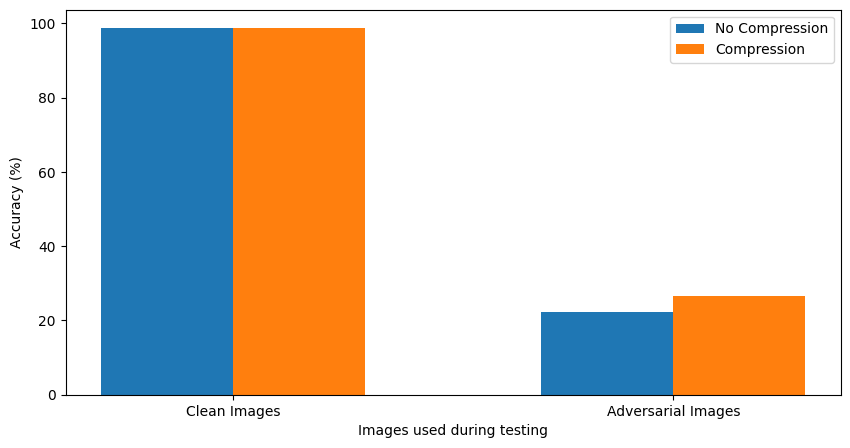

In [41]:
# Plot accuracies
no_compression = [clean_acc_no_compression,attack_acc_no_compression]
compression = [clean_acc_compression,attack_acc_compression]

ind = np.arange(2)

plt.figure(figsize=(10,5))

width=0.3

plt.bar(ind,no_compression, width, label='No Compression')
plt.bar(ind+width,compression,width,label="Compression")

plt.xlabel('Images used during testing')
plt.ylabel('Accuracy (%)')

# xticks()
# First argument - A list of positions at which ticks should be placed
# Second argument -  A list of labels to place at the given locations
plt.xticks(ind + width / 2, ('Clean Images', 'Adversarial Images'))

# Finding the best position for legends and putting it
plt.legend(loc='best')
plt.show()

Using an epsilon value of `0.2`, which means that the perturbations are not as strong as when we would have used a higher epsilon and so the effect of the attack should be lower, we do see a clear effect of the defense. The difference in accuracy when using adversarial images in both cases of using compression or not is very clear. If everything went well, using compression should have increased the accuracy in case of adversarial images, compared to not using compression.

So you see, with only a few lines of codes you can already apply a simple defense against evasion attacks. To apply a good defense, will take some more effort.